## Simple classifier using a KNN algorithm with Levenshtein distance features optimization

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re


### 1. Load data

In [17]:
# open excel-file
data = pd.read_excel('data/KNN (1-3,5).xlsx')  

### 2. Preprocessing

In [18]:
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")
mystem = Mystem()
# data = pd.DataFrame(data[1:], columns=data[0])

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


Функция для предобработки предложений. Что она делает:
+ Лемматизация слов
+ Отбрасывание стоп-слов (частицы, союзы, местоимения)
+ Удаление знаков пунктуации


In [19]:
def preprocess_sentence(sentence):
    tokens = mystem.lemmatize(sentence.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    tokenized_sentence = " ".join(tokens)
    return tokenized_sentence   

Функция для предобротки меток (эмоций) из разметки:

+ Разбиение на отдельные классы
+ Нормализация классов (сведение более мягких эмоций к более сильным)
+ Проверка, что указана корректная эмоция (одна из эмоций по теории Келлермана-Плутчика)

In [20]:
emotions_table = {
    'восторг': 'восторг',
		'радость': 'восторг',
		'безмятежность': 'восторг',
    'восхищение': 'восхищение',
		'доверие': 'восхищение',
		'принятие': 'восхищение',
    'ужас': 'ужас',
		'страх': 'ужас',
		'тревога': 'ужас',
    'изумление': 'изумление',
		'удивление': 'изумление',
		'возбуждение': 'изумление',
    'горе': 'горе',
		'грусть': 'горе',
		'печаль': 'горе',
    'отвращение': 'отвращение',
		'неудовольствие': 'отвращение',
		'скука': 'отвращение',
    'гнев': 'гнев',
		'злость': 'гнев',
		'досада': 'гнев',
    'настороженность': 'настороженность',
		'ожидание': 'настороженность',
		'интерес': 'настороженность',
}

def normalize_emotion(emotion):
    emotion = emotion.lower()
    result = emotions_table.get(emotion)
    assert result is not None, f"Emotion '{emotion}' is not correct one."
    return result

Непосредственно предобработка данных из файла с разметкой:

In [21]:
processed_sentences = list(map(preprocess_sentence, data['Предложение']))
temp = pd.DataFrame(columns=['Предложение', 'Эмоция'])

for i, (emotion, sentence) in enumerate(zip(data['Эмоция'], processed_sentences)):
    if any(delim in emotion for delim in (' ', ',', '.', '\n')):
        emotions = [normalize_emotion(e) for e in re.split('[ ,.\n]', emotion.strip()) if e != '']
        # for e in emotions:
        #     temp = temp.append({'Предложение': sentence, 'Эмоция': e}, ignore_index=True)
        temp = temp.append({'Предложение': sentence, 'Эмоция': emotions[0]}, ignore_index=True)
    else:
        temp = temp.append({'Предложение': sentence, 'Эмоция': normalize_emotion(emotion)}, ignore_index=True)

processed_data = temp

### 3. Modelling with TF-IDF Vectorizer

In [22]:
from typing import List, Iterable, Dict, Tuple

import collections
import itertools
import scipy
import time

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nltk.stem.snowball import RussianStemmer
stemmer = RussianStemmer()

vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(processed_data['Предложение'])

# encode document
tfidf_vec_matrix = vectorizer_tfidf.transform(processed_data['Предложение'])



### 3.1 Обучение классификатора 
Строим модели с разнами разбиениями датасета и разными k для KNN.

In [23]:
DEFAULT_COLORS = ['red', 'green', 'orange', 'purple', 'blue', 'gray', 'pink']
DEFAULT_SPLITS = [0.20, 0.30, 0.40, 0.50]

def get_colors(n):
  colors = DEFAULT_COLORS[:n]
  if n > len(DEFAULT_COLORS):
    import matplotlib, random
    all_colours = matplotlib.colors.get_named_colors_mapping()
    colors.extend(random.choices(all_colours, k=n-len(DEFAULT_COLORS)))
  return colors

def _knn_analysis(X, y, splits, k_interval) -> Tuple[List[List[float]], List[List[float]], Dict[str, int]]:
  error_over_splits_train = []
  error_over_splits_test = []
  best_result = {'split': 0, 'k': 0, 'error': 1}
  for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    #---------------------
    # here could be scaler
    #---------------------
    # Comparing Error Rate with the K Value
    # (calculating error for K values in k_range)
    error_for_one_split = []
    
    err_one_split_test = []
    err_one_split_train = []
    
    for i in k_interval:
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        
        err_train_tmp = np.mean(y_train != y_train_predict)
        err_test_tmp = np.mean(y_test != y_test_predict)
        
        err_one_split_test.append(err_test_tmp)
        err_one_split_train.append(err_train_tmp)
        
        # check the best result
        if err_test_tmp < best_result['error']:
            best_result['split'] = split
            best_result['k'] = i
            best_result['error'] = err_test_tmp
    error_over_splits_train.append(err_one_split_train)
    error_over_splits_test.append(err_one_split_test)
  return error_over_splits_train, error_over_splits_test, best_result

### 3.2 Визуализация результатов

In [24]:
def visualize_knn_analysis(X, y, splits=None, min_k=1, max_k=40):
  if not splits:
    splits = DEFAULT_SPLITS
  k_range = range(min_k, max_k+1)
  
  # Training and Predictions
  errors_over_splits_train, errors_over_splits_test, best_res = _knn_analysis(X, y, splits, k_range)
          
  # Plot results
  plt.figure(num=1, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_train, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)

  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Train Error')
  plt.legend(loc='best')
  
  plt.figure(num=2, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_test, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)
  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Test Error')
  plt.legend(loc='best')
  
  print("Best set:")
  print("Split: " + str(int((1 - best_res['split']) * 100)) + '%/' + str(int(best_res['split'] * 100)) + '%')
  print("K: " + str(best_res['k']))
  print("Error value: " + str(best_res['error']))

### 3.3 Оптимизация пространства признаков

In [25]:
import functools
import multiprocessing
import random

DEFAULT_PREVIEW_SIZE = 5
EXAMPLES_FOR_GROUP_IN_PREVIEW = 3

def map_filter(wi1, wi2, comparator):
  if comparator(wi1[0], wi2[0]):
    return wi1[1], wi2[1]
  return None

def feature_optimize(X:scipy.sparse.csr_matrix, vectorizer, comparator, *,
                     stemming=False, debug=False, preview=DEFAULT_PREVIEW_SIZE,
                     **kwargs) -> scipy.sparse.csr_matrix:
  if len(kwargs) > 0:
    comparator = functools.partial(comparator, **kwargs)
  if preview and not isinstance(preview, int):
    preview = DEFAULT_PREVIEW_SIZE
    if debug:
      print(f'Param `preview` must be type of <int>. Set default value: {preview}')

  def fast_get_similar_cols_multi(df: pd.DataFrame):
    if stemming:
      words_and_ids = [(stemmer.stem(w), i) for i, w in enumerate(df.columns)]
    else:
      words_and_ids = [(w, i) for i, w in enumerate(df.columns)]
    multiproc_filter = functools.partial(map_filter, comparator=comparator)
    data = list(itertools.combinations(words_and_ids, 2))
    pnum = multiprocessing.cpu_count()
    with multiprocessing.Pool(pnum) as pool:
      res = pool.starmap(multiproc_filter, data, len(data) // pnum)
    return filter(None, res)

  df = pd.DataFrame(X.toarray(), columns=vectorizer.vocabulary_)

  # getting similar columns
  similar_col_groups = collections.defaultdict(set)
  if debug:
    start = time.time()
    for i, (col_id1, col_id2) in enumerate(fast_get_similar_cols_multi(df), 1):
      similar_col_groups[col_id1].add(col_id2)
      similar_col_groups[col_id2].add(col_id1)
      if i % 1000 == 0:
        print(f"{i} entries are matched by comparator")
    print('PROCESSING TIME:', time.time() - start)
    print(f'Got similar_col_groups (len: {len(similar_col_groups)})')
  else:
    for col_id1, col_id2 in fast_get_similar_cols_multi(df):
      similar_col_groups[col_id1].add(col_id2)
      similar_col_groups[col_id2].add(col_id1)

  _merge_intersecting_groups(similar_col_groups)
  if debug:
    print('Groups after merging:', len(similar_col_groups))

  # assign words to indices
  similar_col_groups = {
    df.columns[master_index]: [df.columns[i] for i in group]
    for master_index, group in similar_col_groups.items()
  }

  if preview:
    print('Примеры признаков, которые объединены:')
    if preview > len(similar_col_groups):
      preview = len(similar_col_groups)
    some_n_groups_examples = random.sample(similar_col_groups.keys(), preview)
    rendered_groups = []
    for master_col in some_n_groups_examples:
      similar_cols = similar_col_groups[master_col]
      if len(similar_cols) < EXAMPLES_FOR_GROUP_IN_PREVIEW:
          some_n_cols = random.sample(similar_cols, len(similar_cols))
      else:
          some_n_cols = random.sample(similar_cols, EXAMPLES_FOR_GROUP_IN_PREVIEW)
      rendered_group = ', '.join(f"'{col_name}'" for col_name in some_n_cols)
      if len(some_n_cols) < len(similar_cols):
        rendered_group = f'{rendered_group}...'
      rendered_groups.append(f"'{master_col}': {rendered_group}")
    print('\n'.join(rendered_groups))

  df = join_columns(similar_col_groups.items(), df, debug)
  if debug:
    print(f'Columns after: {len(df.columns)}')
  return scipy.sparse.csr_matrix(df.values)

def _merge_intersecting_groups(similar_col_groups):
  def merge_subkeys_into_group(main_key, group, subkeys=None):
    if subkeys is None:
      subkeys = set(group)
    else:
      group.update(subkeys)
    for key in subkeys:
      if key in similar_col_groups:
        new_keys = similar_col_groups[key] - group - {key, main_key}
        if len(new_keys) > 0:
          merge_subkeys_into_group(main_key, group, new_keys)
        del similar_col_groups[key]
  for key in tuple(similar_col_groups.keys()):
    if key in similar_col_groups:
      group = similar_col_groups[key]
      merge_subkeys_into_group(key, group)

def join_columns(column_groups: Iterable[Tuple[str, Iterable[str]]], df: pd.DataFrame, debug) -> pd.DataFrame:
  for master_col, group in column_groups:
    for sub_col in group:
      if sub_col in df.columns:
        try:
          df[master_col] += df[sub_col]
          # df.iloc[:, [col_id]] += df.iloc[:, [sub_col]]
        except Exception as e:
          rendered_cols = ", ".join(f"'{col_name}" for col_name in df.columns)
          rendered_group = ", ".join(f"'{k}'" for k in group)
          print(f"key: '{master_col}'; subkey '{sub_col}' [cols: {rendered_cols}] [group: {rendered_group}]")
          print(f"df[key]: {df[master_col]}; df[subkey]: {df[sub_col]}")
          exit('ERROR')
        df.drop(sub_col, axis=1, inplace=True)
      elif debug:
        rendered_cols = ", ".join(f"'{col_name}" for col_name in df.columns)
        rendered_group = ", ".join(f"'{k}'" for k in group)
        print(f"key: '{master_col}'; subkey '{sub_col}' do not exist in DF [cols: {rendered_cols}] [group: {rendered_group}]")

  return df


## 4. Analysis

#### 4.1 **Baseline**

Best set:
Split: 70%/30%
K: 7
Error value: 0.6333333333333333


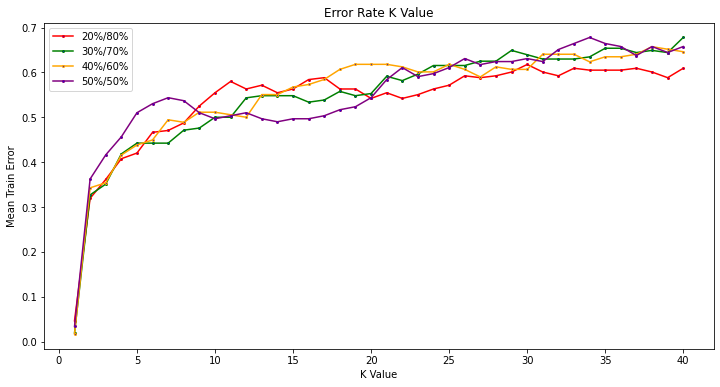

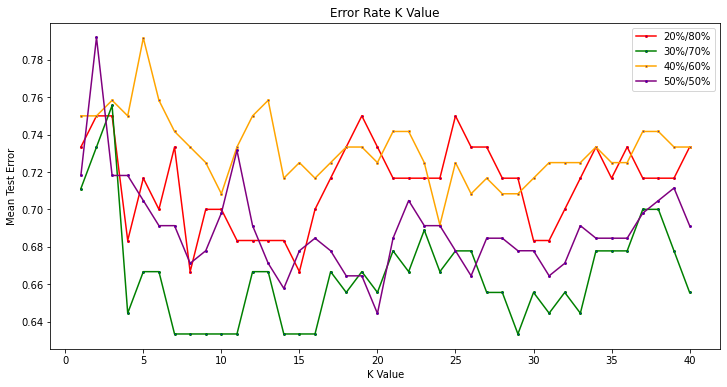

In [26]:
X = tfidf_vec_matrix
y = processed_data['Эмоция'].to_numpy()

visualize_knn_analysis(X, y)

По графику ошибки на обучающей выборке видно, что модель плохо обучается.
На следующем этапе пробуем сократить число признаков(слов), объединив близкие
по какому-либо критерию слова.

#### 4.2 **Оптимизация с Левенштейном**
Пытаемся объединить близкие по расстоянию Левенштейна слова.

Расстояние Левенштейна (редакционное расстояние) 
определяется как минимальное количество односимвольных операций 
(а именно вставки, удаления, замены), 
необходимых для превращения одной последовательности символов в другую. 

##### **Без стемминга**

In [27]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

DEFAULT_THRESHOLD = 80

def levenshtein_similarity(word1, word2, threshold=DEFAULT_THRESHOLD) -> bool:
  return fuzz.WRatio(word1, word2) >= threshold

Количество признаков до оптимизации:  1511
Примеры признаков, которые объединены:
'скамейка': 'камера', 'каморка', 'змейка'
'белок': 'переулок'
'весь': 'вещь'
'очень': 'печень'
'деньги': 'тень', 'день'
Best set:
Split: 80%/20%
K: 34
Error value: 0.6833333333333333


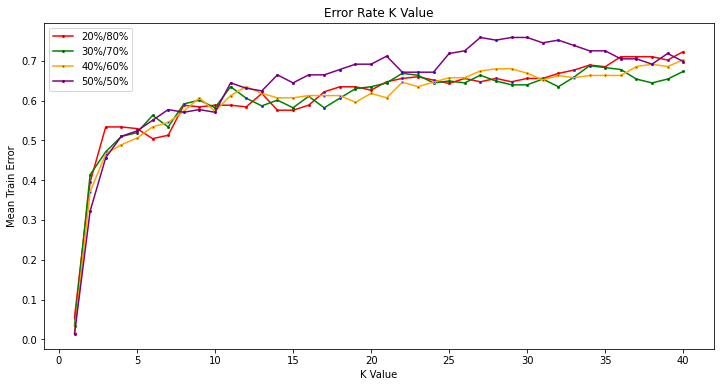

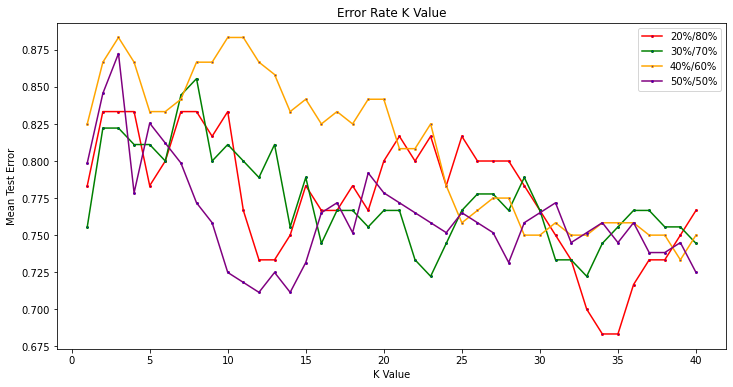

In [28]:
X_lev = feature_optimize(X, vectorizer_tfidf, levenshtein_similarity, stemming=False, threshold=70)
visualize_knn_analysis(X_lev, y)

In [29]:
print("Количество признаков до / после оптимизации: ", X.shape[1], '/', X_lev.shape[1])

Количество признаков до / после оптимизации:  1511 / 202


##### **Со стеммингом**

Примеры признаков, которые объединены:
'опасаться': 'спасаться', 'спасать'
'москва': 'москвич'
'лично': 'публичный'
'чудовище': 'чудо', 'чудовищный', 'чудесный'
'бритый': 'небритый', 'небо'
Best set:
Split: 80%/20%
K: 37
Error value: 0.6333333333333333


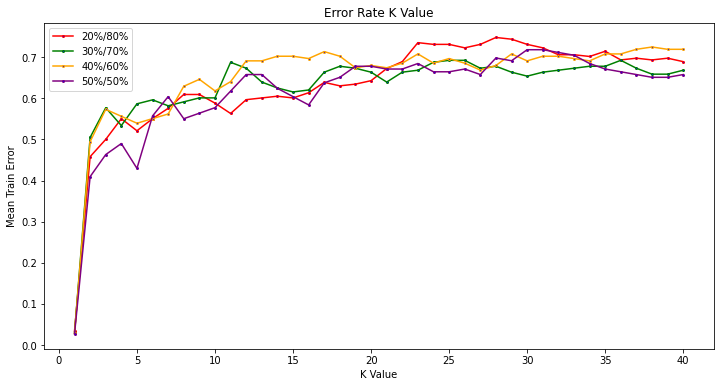

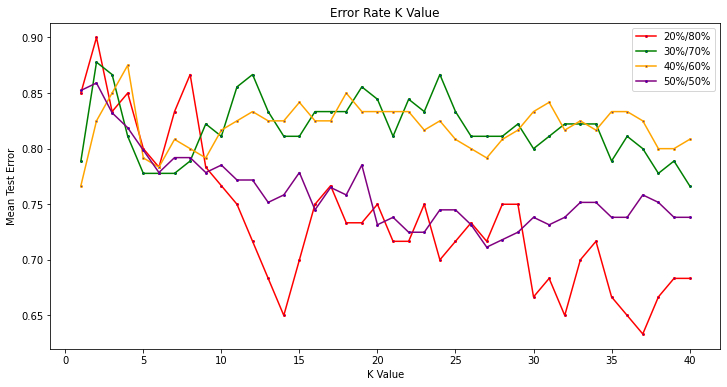

In [30]:
X_lev_stem = feature_optimize(X, vectorizer_tfidf, levenshtein_similarity, stemming=True)
visualize_knn_analysis(X_lev_stem, y)

In [31]:
print("Количество признаков до / после оптимизации: ", X.shape[1], '/', X_lev_stem.shape[1])



Количество признаков до / после оптимизации:  1511 / 357
